In [1]:

# Auto-reload external modules when their source changes
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import src.train as train
import src.models as models
import utils.helpers as helpers
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# Path variables
BASE_PATH = "src/inputs/"
TRAIN_PATH = BASE_PATH + "train.csv"
TEST_PATH = BASE_PATH + "test.csv"
train_jpg = glob(BASE_PATH + "train/*.jpg")
test_jpg = glob(BASE_PATH + "test/*.jpg")



c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


1. Data Loading and EDA
2. Models Application  
> 
 - 2.1)   Vision Transformer (images+metadata)  
 - 2.2)   Swin Transformer (images)  

In [2]:
# to set the seeds for reproducibility
helpers.set_seeds()

Loading train and test csv files

In [3]:
train_df = pd.read_csv(BASE_PATH + "train.csv")
test_df =  pd.read_csv(BASE_PATH + "test.csv")


In [4]:
print("train shape:",train_df.shape)
print("test shape",test_df.shape)


train shape: (9912, 14)
test shape (8, 13)


In [5]:
train_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  
0          0      1        0      0          0     0     0           63  
1          0      0        0      0          0     0     0           42  
2          0      0        0      1          1     0     0           28  
3          0      0        0      0          0     0     0           15  
4          0      1        0      0          0     0     0           72

In [6]:
test_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   
2  4e429cead1848a298432a0acad014c9d              0     0     0     1       0   
3  80bc3ccafcc51b66303c2c263aa38486              1     0     1     0       0   
4  8f49844c382931444e68dffbe20228f4              1     1     1     0       1   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  
0          1      1        0      0          1     0     1  
1          0      1        1      0          0     0     0  
2          1      1        1      0          1     1     1  
3          0      0        0      0          0     1     0  
4          1      0        1      0          1     1     0

The train.csv and test.csv files contain metadata for photos in the training set and test set, respectively. Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features:

Focus - Pet stands out against uncluttered background, not too close / far.  
Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.  
Face - Decently clear face, facing front or near-front.  
Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).  
Action - Pet in the middle of an action (e.g., jumping).  
Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.  
Group - More than 1 pet in the photo.  
Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).  
Human - Human in the photo.  
Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.  
Info - Custom-added text or labels (i.e. pet name, description).  
Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0.  

In [7]:
print("Null Values: ",train_df.isnull().sum())
print("Duplicate Values: ",train_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
Pawpularity      0
dtype: int64
Duplicate Values:  0


In [8]:
print("Null Values: ",test_df.isnull().sum())
print("Duplicate Values: ",test_df.duplicated().sum())

Null Values:  Id               0
Subject Focus    0
Eyes             0
Face             0
Near             0
Action           0
Accessory        0
Group            0
Collage          0
Human            0
Occlusion        0
Info             0
Blur             0
dtype: int64
Duplicate Values:  0


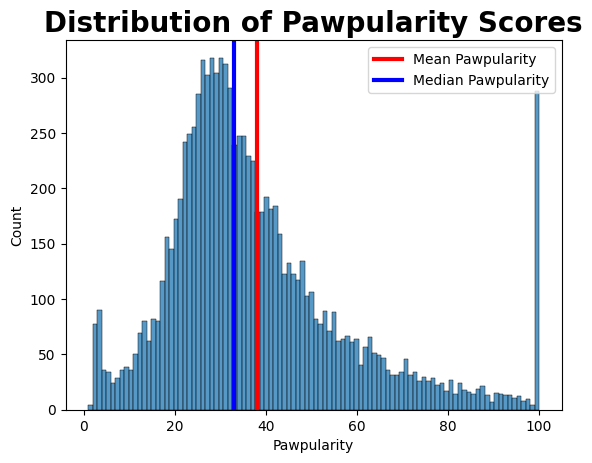

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444
There are 100 unique values of Pawpularity score


In [9]:
#To check the distribution of Pawpularity Scores

helpers.plotDistribution(train_df)

print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")


> From the distribution graph above, we can see that pets with Pawpularity score 20 to 40 are more, Also there is a high peak at 100 score, but before that most of the pets have the score from around ~60 - ~90 .  

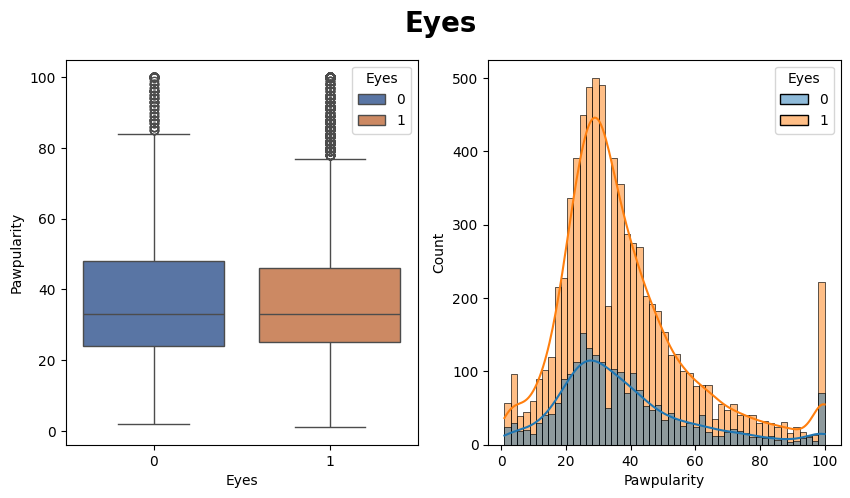

In [10]:
#showing one feature with the Pawpularity
helpers.plotDistributionAcrossEachFeature(["Eyes"],train_df)

> For the single feature like "Eye", both categories "0", "1" are similar as shown in the box plot, However we can see that those with high pawpularity are mostly the pets facing front or near-front, with at least 1 eye / pupil decently clear. 

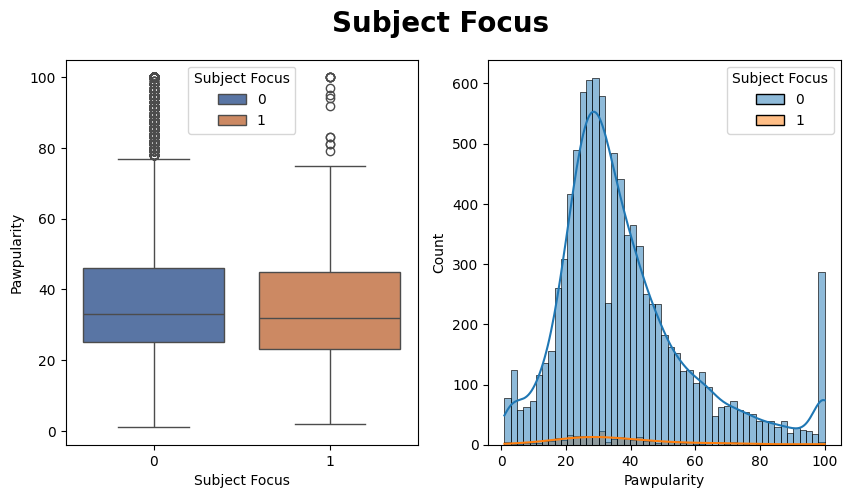

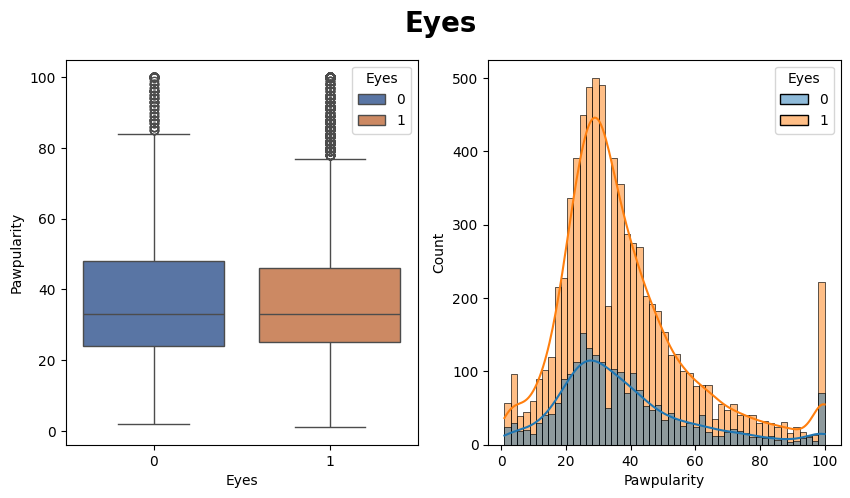

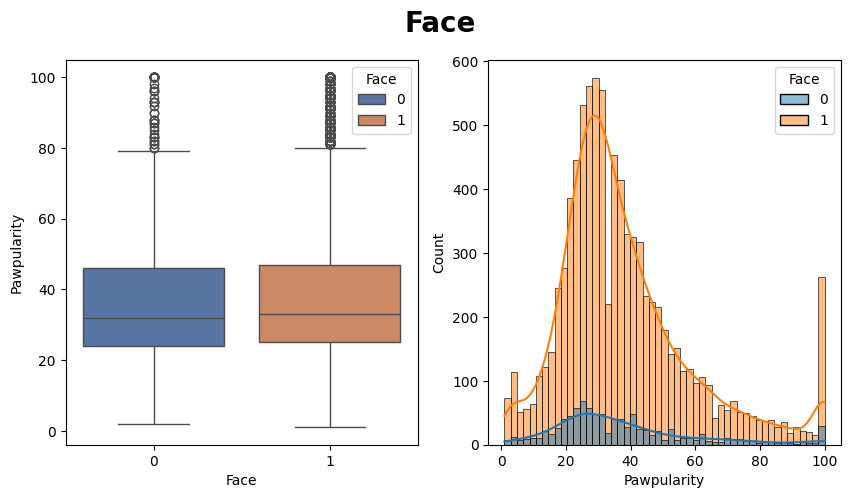

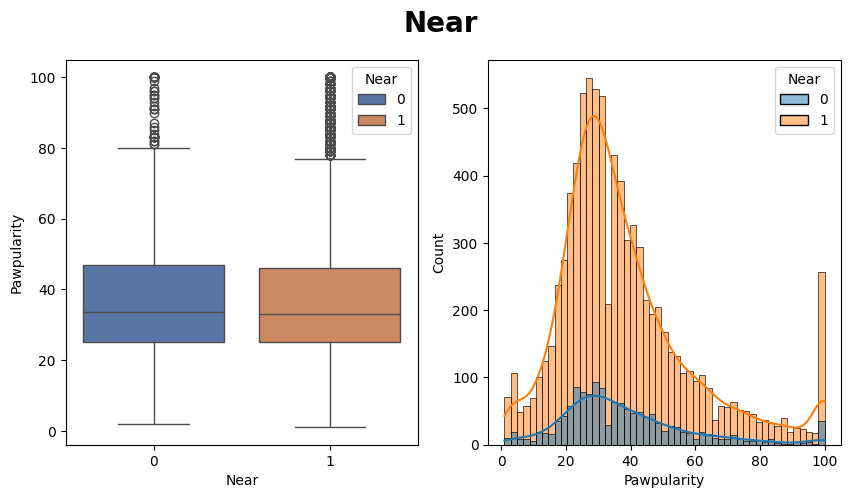

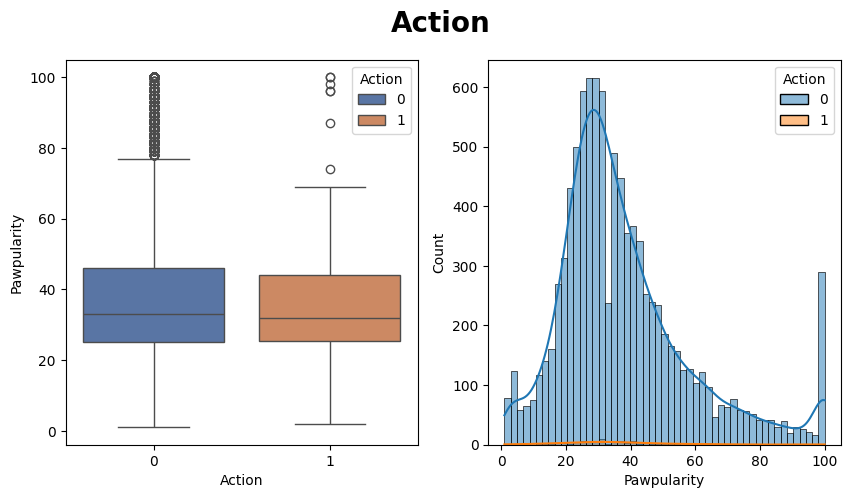

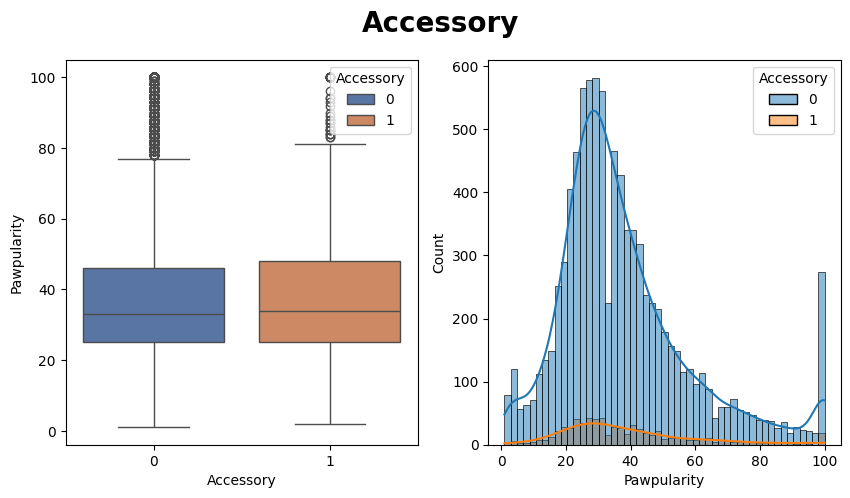

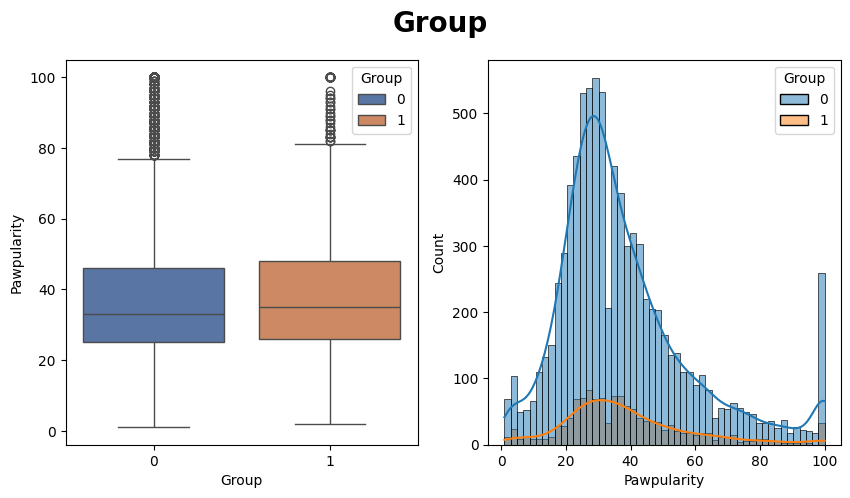

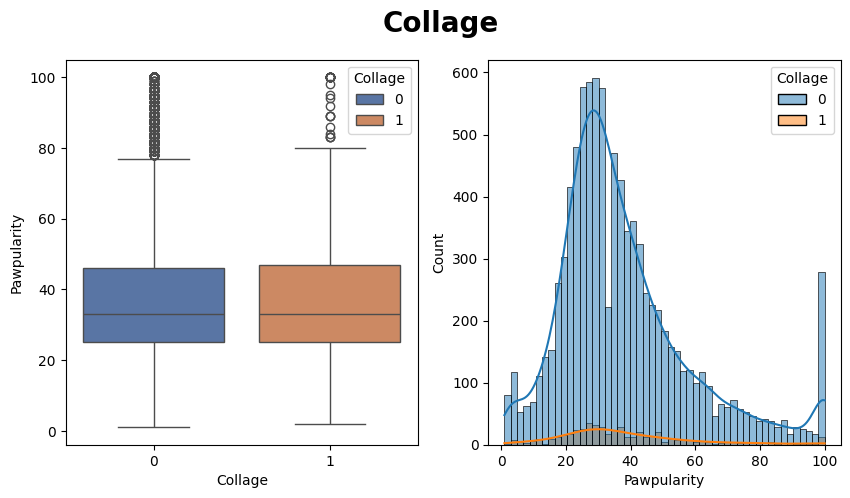

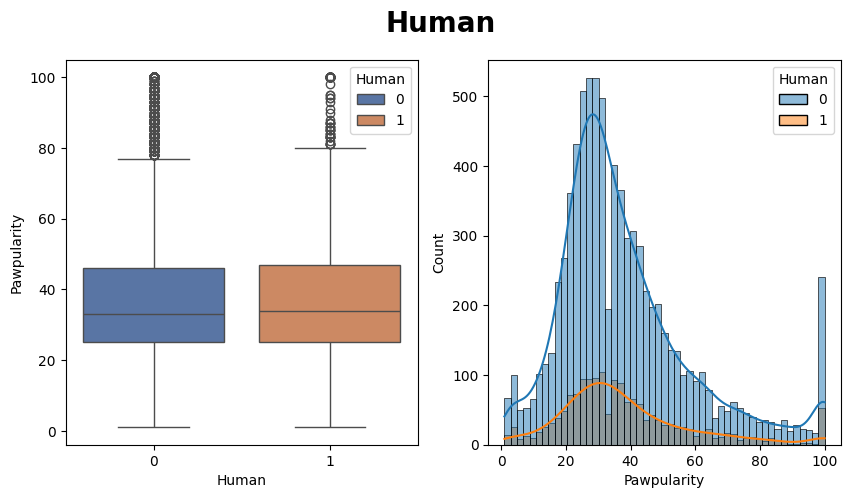

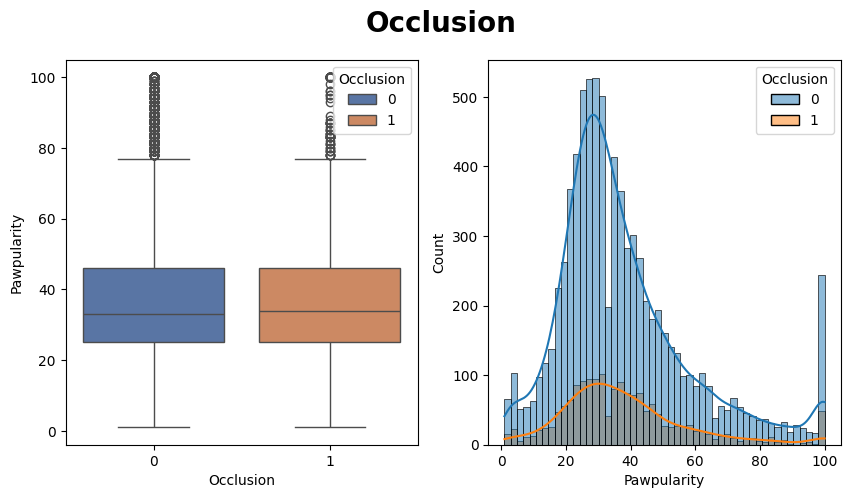

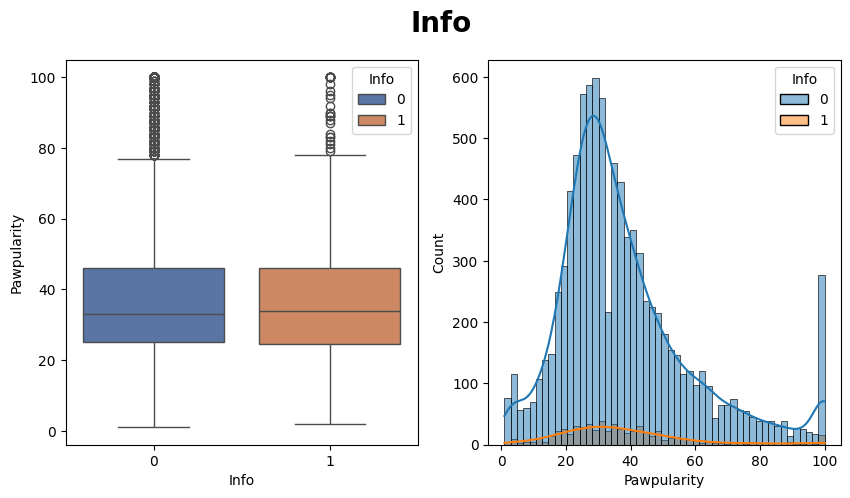

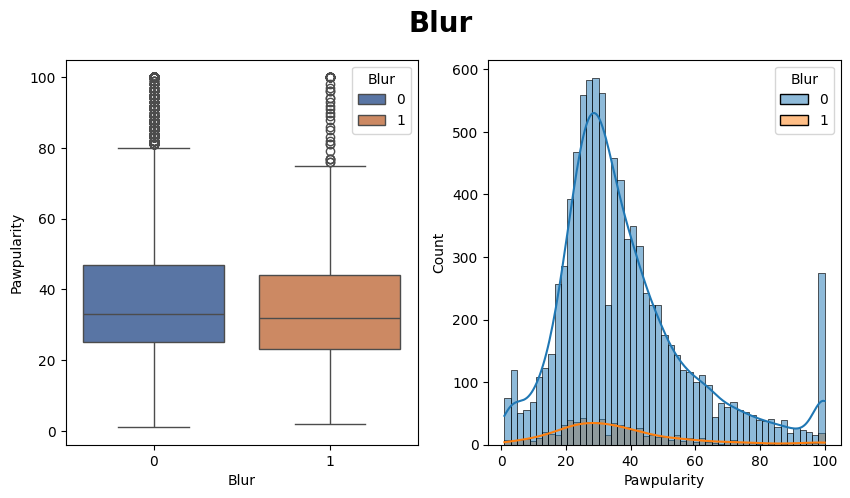

In [76]:
# Let's all features
feature_variables = train_df.columns.values.tolist()[1:-1] #to exclude id and Pawpularity
helpers.plotDistributionAcrossEachFeature(feature_variables,train_df)

### Week-1,Feedback 1
(Assignment: Add the correlation matrix and VIF calculation code to your notebook, and make sure to include explanatory comments.)

> Looking at the above distribtions, we can see the usually the pets with less blur, no object or human inclusion, without frame and tools, near are labelled with high score, Now let's if there is any correlation between the feature and pawpularity as well as multicollinearity which describe if the features are correlated with each other (we can use correlation matrix and VIF- Variance Inflation Factor )

1. Correlation Matrix shows the how two variable are related/affected by each other
2. VIF describes how one variable is related with all other input features

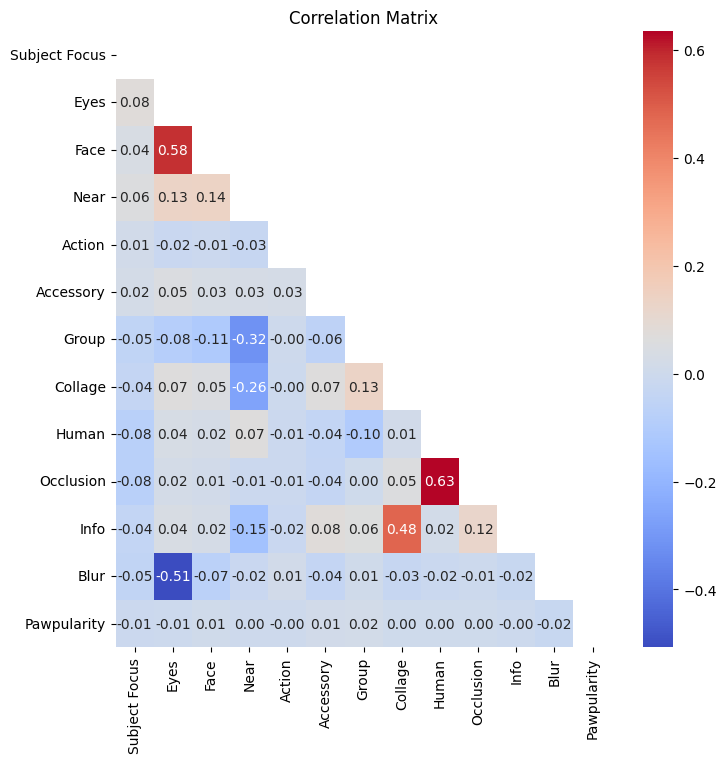

Subject Focus   -0.009853
Eyes            -0.006686
Face             0.008018
Near             0.001001
Action          -0.001373
Accessory        0.013287
Group            0.016469
Collage          0.001732
Human            0.003983
Occlusion        0.001979
Info            -0.004735
Blur            -0.023540
Name: Pawpularity, dtype: float64


In [12]:

helpers.plotCorrelationMatrix(train_df)


> Here we can see that there is not much significance correlation between the feature and pawpuarlity, However there is some correlation between the input features like Face and Eyes, Human and Occlusion.

>   The first between Occlusion and Human (Humans can hide part of the animal)
The second between Face and Eyes which means If the face is clear and front-facing, chances are both eyes are also visible and clear. 

In [13]:
helpers.calculateVIF(train_df.loc[:, ~train_df.columns.isin(["Id", "Pawpularity"])])

feature        VIF
2            Face  13.715668
1            Eyes  10.118170
3            Near   5.762924
9       Occlusion   2.073562
8           Human   2.064939
11           Blur   1.595109
7         Collage   1.452023
10           Info   1.412621
6           Group   1.163850
5       Accessory   1.090942
0   Subject Focus   1.048292
4          Action   1.010174

> #### Here we can see that Face and Eyes are high correclated, which signal to use some regularization when we apply model on meta data

### Now let's explore images

In [14]:
id_stem = Path(train_jpg[0]).stem
print('Original: ', train_jpg[0])
print('After: ', id_stem)


Original:  src/inputs/train\0007de18844b0dbbb5e1f607da0606e0.jpg
After:  0007de18844b0dbbb5e1f607da0606e0


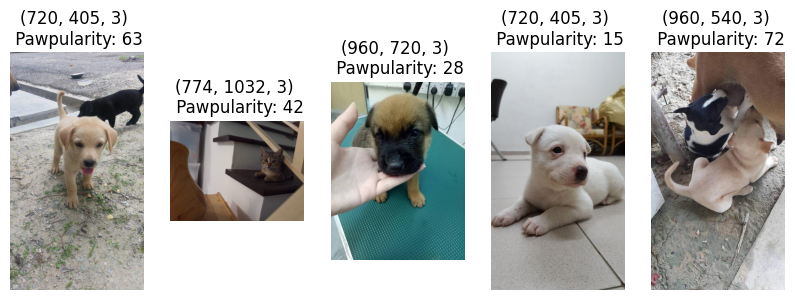

In [15]:
#let's see first 5 images
helpers.showPicture(5, train_jpg, train_df)

In [16]:
#Let's see the lowest and highest score images
print(train_df["Pawpularity"].max())
print(train_df["Pawpularity"].min())


100
1


In [17]:
train_df_max_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].max(),"Id"].iloc[0]
train_df_min_id =  train_df.loc[train_df["Pawpularity"] == train_df["Pawpularity"].min(),"Id"].iloc[0]

In [18]:
filtered_jpg = [p for p in train_jpg if Path(p).stem in [train_df_max_id,train_df_min_id]]

##### let's check the high Pawpularity and low Pawpularity images

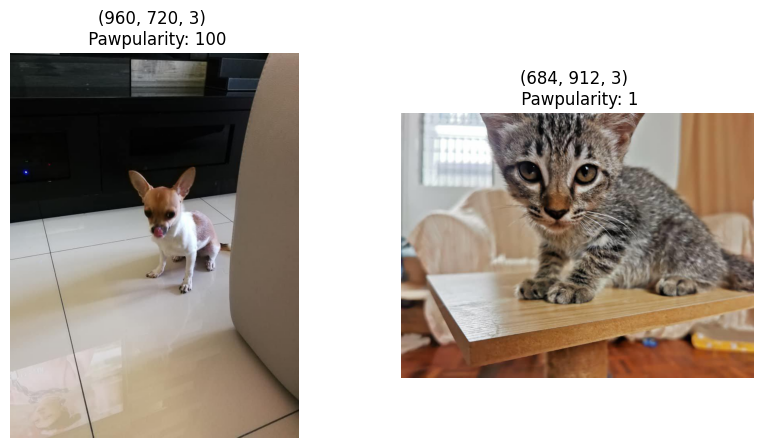

In [19]:
helpers.showPicture(2, filtered_jpg, train_df)

In [20]:
train_df

Id  Subject Focus  Eyes  Face  Near  \
0     0007de18844b0dbbb5e1f607da0606e0              0     1     1     1   
1     0009c66b9439883ba2750fb825e1d7db              0     1     1     0   
2     0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1   
3     0018df346ac9c1d8413cfcc888ca8246              0     1     1     1   
4     001dc955e10590d3ca4673f034feeef2              0     0     0     1   
...                                ...            ...   ...   ...   ...   
9907  ffbfa0383c34dc513c95560d6e1fdb57              0     0     0     1   
9908  ffcc8532d76436fc79e50eb2e5238e45              0     1     1     1   
9909  ffdf2e8673a1da6fb80342fa3b119a20              0     1     1     1   
9910  fff19e2ce11718548fa1c5d039a5192a              0     1     1     1   
9911  fff8e47c766799c9e12f3cb3d66ad228              0     1     1     1   

      Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          0          0      1        0      0          0     0     0   
1          0          0      0        0      0          0     0     0   
2          0          0      0        0      1          1     0     0   
3          0          0      0        0      0          0     0     0   
4          0          0      1        0      0          0     0     0   
...      ...        ...    ...      ...    ...        ...   ...   ...   
9907       0          0      0        0      0          0     0     1   
9908       0          0      0        0      0          0     0     0   
9909       0          0      0        0      1          1     0     0   
9910       0          0      0        0      1          0     0     0   
9911       0          0      0        0      0          0     0     0   

      Pawpularity  
0              63  
1              42  
2              28  
3              15  
4              72  
...           ...  
9907           15  
9908           70  
9909           20  
9910           20  
9911           30  

[9912 rows x 14 columns]

<br>



### Week-1, Feedback 2
 (Add the code for computing image features(Brightness, Contrast, saturation, sharpness, edge density, resolution, aspect ration) and visualizing their relationship with the target to your notebook, and include explanatory comments)

> Now we will check some other pattern from image and will their correlation with target pawpularity 

In [21]:
len(train_df)

9912

In [11]:
# adding the image path to the metadata table
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')
# this function will calculate edges, brightness,contrast etc for each image 
features_list = helpers.extractFeature(train_df)
print(len(features_list))


9912


In [23]:
img_features_df = pd.DataFrame(features_list)

# Merging with metadata table
merged_df = train_df.merge(img_features_df, on='Id')

print(len(merged_df))

9912


In [24]:
merged_df.head()

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  ...  Pawpularity  \
0          0      1        0      0  ...           63   
1          0      0        0      0  ...           42   
2          0      0        0      1  ...           28   
3          0      0        0      0  ...           15   
4          0      1        0      0  ...           72   

                                                path  brightness   contrast  \
0  src/inputs/train/0007de18844b0dbbb5e1f607da060...  149.636001  47.226252   
1  src/inputs/train/0009c66b9439883ba2750fb825e1d...   95.569681  55.386129   
2  src/inputs/train/0013fd999caf9a3efe1352ca1b0d9...  117.427021  58.077102   
3  src/inputs/train/0018df346ac9c1d8413cfcc888ca8...  156.972733  50.189218   
4  src/inputs/train/001dc955e10590d3ca4673f034fee...  129.294448  54.795065   

   saturation    sharpness  edge_density  width  height  aspect_ratio  
0   26.977051  4434.230369      0.221547    405     720      0.562500  
1   65.260191    28.845254      0.009222   1032     774      1.333333  
2  100.025308   151.709166      0.037694    720     960      0.750000  
3   27.387541   418.406313      0.028875    405     720      0.562500  
4   35.232224  2241.652292      0.156723    540     960      0.562500  

[5 rows x 23 columns]

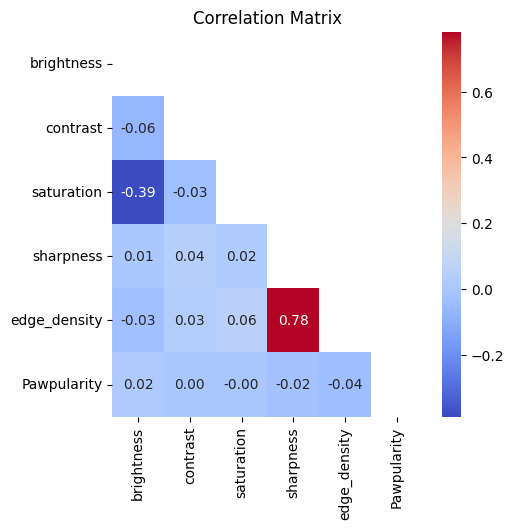

brightness      0.017841
contrast        0.001438
saturation     -0.003212
sharpness      -0.020849
edge_density   -0.036936
Name: Pawpularity, dtype: float64


In [26]:

added_features = ['Id','brightness', 'contrast', 'saturation', 'sharpness', 'edge_density','Pawpularity']
helpers.plotCorrelationMatrix(merged_df[added_features],figsize=(5,5))

> None of these individual image features have a strong  correlation with Pawpularity. 

> # Week 2 Start

# 2 Models Exploration
There are two models considered including vision transformer for images + metadata combination. The second algorithm is swin transformer applied only on the images

###  2.1 Vision transformer


- ViT is a deep learning model that applies the Transformer architecture (originally used in NLP) to image data. It splits the image into patches (like small tiles). Each patch is flattened and treated like a token (similar to words in NLP). These tokens are passed through Transformer layers that use self-attention to learn relationships between patches.
ViT captures global context better than CNNs, which focus more on local features. 

In [11]:
#path column added to access the images path
train_df['path'] = train_df['Id'].map(lambda x:str(BASE_PATH+'train/'+x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1     1       0          0      0        0      0   
1              0     1     1     0       0          0      0        1      0   
2              0     1     1     1       0          1      0        0      0   
3              0     0     1     1       0          0      1        0      0   
4              0     1     1     1       0          0      1        0      0   

   Occlusion  Info  Blur  Pawpularity  \
0          0     0     0           40   
1          0     0     0           64   
2          0     0     0           26   
3          0     0     0           73   
4          0     0     0           39   

                                                path  
0  src/inputs/train/48d53aeabee4f92f77eee3a323343...  
1  src/inputs/train/b60e82fd313066b801fa4431d1ce4...  
2  src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...  
3  src/inputs/train/263879abce68de4af02ef5f7ef873...  
4  src/inputs/train/4ea0587a137c7983ca92851b6cb36...

In [12]:
#normalizing 
train_df['norm_score'] = train_df['Pawpularity']/100
train_df.head()

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1     1       0          0      0        0      0   
1              0     1     1     0       0          0      0        1      0   
2              0     1     1     1       0          1      0        0      0   
3              0     0     1     1       0          0      1        0      0   
4              0     1     1     1       0          0      1        0      0   

   Occlusion  Info  Blur  Pawpularity  \
0          0     0     0           40   
1          0     0     0           64   
2          0     0     0           26   
3          0     0     0           73   
4          0     0     0           39   

                                                path  norm_score  
0  src/inputs/train/48d53aeabee4f92f77eee3a323343...        0.40  
1  src/inputs/train/b60e82fd313066b801fa4431d1ce4...        0.64  
2  src/inputs/train/09ae71fc4eda1e0ae05680d1950bc...        0.26  
3  src/inputs/train/263879abce68de4af02ef5f7ef873...        0.73  
4  src/inputs/train/4ea0587a137c7983ca92851b6cb36...        0.39

In [13]:
from src.data import (
    get_config, 
    get_params, 
    createfolds, 
    get_train_transforms, 
    get_valid_transforms
)
# Get configuration and parameters
config = get_config()


# Create stratified folds
traindf = createfolds(train_df, config['numfolds'], config['seed'])

# Define features
target = ['Pawpularity']
not_features = ['Id', 'kfold', 'path', 'Pawpularity']
cols = list(traindf.columns)
features = [feat for feat in cols if feat not in not_features]
params = get_params(features)
print(f"Features being used: {features}")

# Initialize transforms
train_transforms = get_train_transforms(dim=params['imsize'])
valid_transforms = get_valid_transforms(dim=params['imsize'])




Features being used: ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'norm_score']


In [14]:
import numpy as np
import torch
import torch.nn as nn
from src.data import (
    get_config, get_params, createfolds, get_train_transforms, get_valid_transforms, CuteDataset
)
from torch.utils.data import DataLoader

from utils.helpers import get_scheduler, show_image
from src.models import PetNet
from src.train import train_fn
from src.eval import validate_fn
import gc
import os

In [15]:
def run_cross_validation(train_df, params, TRAIN_FOLDS):
    """
    Main loop for k-fold cross-validation training and validation.
    """
    best_models_of_each_fold = []
    rmse_tracker = []
    EPOCHS = params.get('epochs', 10)

    for fold in TRAIN_FOLDS:
        print(''.join(['#'] * 50))
        print(f"{''.join(['='] * 15)} TRAINING FOLD: {fold + 1}/{train_df['kfold'].nunique()} {''.join(['='] * 15)}")

        # 1. Data Split
        train = train_df[train_df['kfold'] != fold].reset_index(drop=True)
        valid = train_df[train_df['kfold'] == fold].reset_index(drop=True)

        X_train = train['path']
        X_train_dense = train[params['densefeatures']]
        y_train = train['Pawpularity'] / 100 # Scale target to 0-1
        X_valid = valid['path']
        X_valid_dense = valid[params['densefeatures']]
        y_valid = valid['Pawpularity'] / 100 # Scale target to 0-1

        # 2. Pytorch Dataset Creation
        train_dataset = CuteDataset(
            images_filepaths=X_train.values,
            dense_features=X_train_dense.values,
            targets=y_train.values,
            transform=get_train_transforms(dim=params['imsize'])
        )

        valid_dataset = CuteDataset(
            images_filepaths=X_valid.values,
            dense_features=X_valid_dense.values,
            targets=y_valid.values,
            transform=get_valid_transforms(dim=params['imsize'])
        )

        # 3. Pytorch Dataloader creation
        train_loader = DataLoader(
            train_dataset, batch_size=params['batchsize'], shuffle=True,
            num_workers=params['numworkers'], pin_memory=True
        )

        val_loader = DataLoader(
            valid_dataset, batch_size=params['batchsize'], shuffle=False,
            num_workers=params['numworkers'], pin_memory=True
        )

        # 4. Model, Loss, Optimizer, Scheduler Setup
        model = PetNet(
            model_name=params['model'],
            out_features=params['outfeatures'],
            inp_channels=params['inpchannels'],
            pretrained=params['pretrained'],
            num_dense=len(params['densefeatures']),
            dropout=params['dropout']
        )
        model = model.to(params['device'])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.AdamW(model.parameters(), 
                                      lr=params['lr'],
                                      weight_decay=params['weight_decay'],
                                      amsgrad=False)
        scheduler = get_scheduler(optimizer, params)

        # 5. Training and Validation Loop
        best_rmse = np.inf
        best_epoch = -1
        best_model_name = None

        for epoch in range(1, EPOCHS + 1):
            train_rmse = train_fn(train_loader, model, criterion, optimizer, epoch, params, scheduler)
            _, _, val_rmse = validate_fn(val_loader, model, criterion, epoch, params)

            if val_rmse < best_rmse:
                best_rmse = val_rmse
                best_epoch = epoch
                
                if best_model_name is not None:
                    try:
                        os.remove(best_model_name)
                    except OSError:
                        pass

                current_model_name = f"{params['model']}_{epoch:02}_epoch_f{fold+1}_{val_rmse:.4f}_rmse.pth"
                torch.save(model.state_dict(), current_model_name)
                best_model_name = current_model_name

        # 6. Summary and Cleanup
        print('')
        print(f'The best RMSE: {best_rmse:.4f} for fold {fold+1} was achieved on epoch: {best_epoch}.')
        print(f'The Best saved model is: {best_model_name}')
        best_models_of_each_fold.append(best_model_name)
        rmse_tracker.append(best_rmse)
        print(''.join(['#'] * 50))
        
        del model, train_loader, val_loader, train_dataset, valid_dataset
        gc.collect()
        torch.cuda.empty_cache()
    
    # Final summary
    print('')
    print(f'Average RMSE of all folds: {np.mean(rmse_tracker):.4f}')
    return best_models_of_each_fold, rmse_tracker



In [9]:
TRAIN_FOLDS = [0, 1, 2, 3, 4]

print("\nStarting cross-validation...")
best_models, final_rmse_tracker = run_cross_validation(train_df, params, TRAIN_FOLDS)

print("\n--- Final Summary ---")
print(f"Trained models: {best_models}")
print(f"Average RMSE: {np.mean(final_rmse_tracker):.4f}")







Starting cross-validation...
##################################################
=============== TRAINING FOLD: 1/5 ===============


Epoch: 01. Train. Loss: 0.665: 100%|██████████| 248/248 [08:30<00:00,  2.06s/it]


Epoch 01 | Train Loss: 0.6655 | Train RMSE: 20.765


Epoch: 01. Valid. Loss: 0.653: 100%|██████████| 62/62 [01:13<00:00,  1.19s/it]


Epoch 01 | Valid Loss: 0.6530 | Valid RMSE: 19.161


Epoch: 02. Train. Loss: 0.655: 100%|██████████| 248/248 [08:01<00:00,  1.94s/it]


Epoch 02 | Train Loss: 0.6553 | Train RMSE: 19.550


Epoch: 02. Valid. Loss: 0.648: 100%|██████████| 62/62 [00:57<00:00,  1.08it/s]


Epoch 02 | Valid Loss: 0.6481 | Valid RMSE: 18.543


Epoch: 03. Train. Loss: 0.652: 100%|██████████| 248/248 [08:07<00:00,  1.96s/it]


Epoch 03 | Train Loss: 0.6516 | Train RMSE: 19.087


Epoch: 03. Valid. Loss: 0.646: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


Epoch 03 | Valid Loss: 0.6461 | Valid RMSE: 18.294


Epoch: 04. Train. Loss: 0.648: 100%|██████████| 248/248 [07:54<00:00,  1.91s/it]


Epoch 04 | Train Loss: 0.6483 | Train RMSE: 18.667


Epoch: 04. Valid. Loss: 0.644: 100%|██████████| 62/62 [00:55<00:00,  1.12it/s]


Epoch 04 | Valid Loss: 0.6436 | Valid RMSE: 17.968


Epoch: 05. Train. Loss: 0.646: 100%|██████████| 248/248 [08:46<00:00,  2.12s/it]


Epoch 05 | Train Loss: 0.6465 | Train RMSE: 18.432


Epoch: 05. Valid. Loss: 0.642: 100%|██████████| 62/62 [01:11<00:00,  1.16s/it]


Epoch 05 | Valid Loss: 0.6423 | Valid RMSE: 17.793


Epoch: 06. Train. Loss: 0.643: 100%|██████████| 248/248 [09:41<00:00,  2.35s/it]


Epoch 06 | Train Loss: 0.6435 | Train RMSE: 18.048


Epoch: 06. Valid. Loss: 0.642: 100%|██████████| 62/62 [01:08<00:00,  1.10s/it]


Epoch 06 | Valid Loss: 0.6418 | Valid RMSE: 17.720


Epoch: 07. Train. Loss: 0.641: 100%|██████████| 248/248 [08:57<00:00,  2.17s/it]


Epoch 07 | Train Loss: 0.6411 | Train RMSE: 17.738


Epoch: 07. Valid. Loss: 0.642: 100%|██████████| 62/62 [01:07<00:00,  1.09s/it]


Epoch 07 | Valid Loss: 0.6424 | Valid RMSE: 17.812


Epoch: 08. Train. Loss: 0.640: 100%|██████████| 248/248 [08:53<00:00,  2.15s/it]


Epoch 08 | Train Loss: 0.6402 | Train RMSE: 17.616


Epoch: 08. Valid. Loss: 0.640: 100%|██████████| 62/62 [01:07<00:00,  1.09s/it]


Epoch 08 | Valid Loss: 0.6401 | Valid RMSE: 17.501


Epoch: 09. Train. Loss: 0.636: 100%|██████████| 248/248 [08:55<00:00,  2.16s/it]


Epoch 09 | Train Loss: 0.6363 | Train RMSE: 17.080


Epoch: 09. Valid. Loss: 0.640: 100%|██████████| 62/62 [01:07<00:00,  1.09s/it]


Epoch 09 | Valid Loss: 0.6404 | Valid RMSE: 17.542


Epoch: 10. Train. Loss: 0.634: 100%|██████████| 248/248 [08:55<00:00,  2.16s/it]


Epoch 10 | Train Loss: 0.6344 | Train RMSE: 16.817


Epoch: 10. Valid. Loss: 0.641: 100%|██████████| 62/62 [01:07<00:00,  1.08s/it]


Epoch 10 | Valid Loss: 0.6406 | Valid RMSE: 17.572

The best RMSE: 17.5009 for fold 1 was achieved on epoch: 8.
The Best saved model is: vit_large_patch32_384_08_epoch_f1_17.5009_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 2/5 ===============


Epoch: 01. Train. Loss: 0.665: 100%|██████████| 248/248 [19:14<00:00,  4.65s/it]


Epoch 01 | Train Loss: 0.6650 | Train RMSE: 20.686


Epoch: 01. Valid. Loss: 0.656: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


Epoch 01 | Valid Loss: 0.6560 | Valid RMSE: 19.600


Epoch: 02. Train. Loss: 0.657: 100%|██████████| 248/248 [19:27<00:00,  4.71s/it]


Epoch 02 | Train Loss: 0.6565 | Train RMSE: 19.671


Epoch: 02. Valid. Loss: 0.651: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


Epoch 02 | Valid Loss: 0.6512 | Valid RMSE: 19.017


Epoch: 03. Train. Loss: 0.652: 100%|██████████| 248/248 [19:24<00:00,  4.69s/it]


Epoch 03 | Train Loss: 0.6515 | Train RMSE: 19.054


Epoch: 03. Valid. Loss: 0.648: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Epoch 03 | Valid Loss: 0.6482 | Valid RMSE: 18.634


Epoch: 04. Train. Loss: 0.649: 100%|██████████| 248/248 [19:23<00:00,  4.69s/it]


Epoch 04 | Train Loss: 0.6485 | Train RMSE: 18.679


Epoch: 04. Valid. Loss: 0.647: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Epoch 04 | Valid Loss: 0.6473 | Valid RMSE: 18.520


Epoch: 05. Train. Loss: 0.646: 100%|██████████| 248/248 [19:23<00:00,  4.69s/it]


Epoch 05 | Train Loss: 0.6456 | Train RMSE: 18.296


Epoch: 05. Valid. Loss: 0.646: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Epoch 05 | Valid Loss: 0.6457 | Valid RMSE: 18.320


Epoch: 06. Train. Loss: 0.644: 100%|██████████| 248/248 [19:22<00:00,  4.69s/it]


Epoch 06 | Train Loss: 0.6444 | Train RMSE: 18.147


Epoch: 06. Valid. Loss: 0.645: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Epoch 06 | Valid Loss: 0.6447 | Valid RMSE: 18.199


Epoch: 07. Train. Loss: 0.641: 100%|██████████| 248/248 [19:39<00:00,  4.76s/it]


Epoch 07 | Train Loss: 0.6414 | Train RMSE: 17.749


Epoch: 07. Valid. Loss: 0.644: 100%|██████████| 62/62 [00:44<00:00,  1.40it/s]


Epoch 07 | Valid Loss: 0.6438 | Valid RMSE: 18.084


Epoch: 08. Train. Loss: 0.640: 100%|██████████| 248/248 [21:37<00:00,  5.23s/it]


Epoch 08 | Train Loss: 0.6395 | Train RMSE: 17.505


Epoch: 08. Valid. Loss: 0.643: 100%|██████████| 62/62 [00:40<00:00,  1.52it/s]


Epoch 08 | Valid Loss: 0.6434 | Valid RMSE: 18.020


Epoch: 09. Train. Loss: 0.636: 100%|██████████| 248/248 [20:21<00:00,  4.93s/it]


Epoch 09 | Train Loss: 0.6362 | Train RMSE: 17.041


Epoch: 09. Valid. Loss: 0.644: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Epoch 09 | Valid Loss: 0.6440 | Valid RMSE: 18.110


Epoch: 10. Train. Loss: 0.635: 100%|██████████| 248/248 [19:22<00:00,  4.69s/it]


Epoch 10 | Train Loss: 0.6349 | Train RMSE: 16.857


Epoch: 10. Valid. Loss: 0.643: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


Epoch 10 | Valid Loss: 0.6435 | Valid RMSE: 18.038

The best RMSE: 18.0203 for fold 2 was achieved on epoch: 8.
The Best saved model is: vit_large_patch32_384_08_epoch_f2_18.0203_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 3/5 ===============


Epoch: 01. Train. Loss: 0.663: 100%|██████████| 248/248 [07:52<00:00,  1.90s/it]


Epoch 01 | Train Loss: 0.6631 | Train RMSE: 20.455


Epoch: 01. Valid. Loss: 0.655: 100%|██████████| 62/62 [00:56<00:00,  1.10it/s]


Epoch 01 | Valid Loss: 0.6554 | Valid RMSE: 19.566


Epoch: 02. Train. Loss: 0.657: 100%|██████████| 248/248 [07:27<00:00,  1.80s/it]


Epoch 02 | Train Loss: 0.6566 | Train RMSE: 19.680


Epoch: 02. Valid. Loss: 0.650: 100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


Epoch 02 | Valid Loss: 0.6503 | Valid RMSE: 18.944


Epoch: 03. Train. Loss: 0.653: 100%|██████████| 248/248 [07:27<00:00,  1.80s/it]


Epoch 03 | Train Loss: 0.6529 | Train RMSE: 19.218


Epoch: 03. Valid. Loss: 0.647: 100%|██████████| 62/62 [00:56<00:00,  1.11it/s]


Epoch 03 | Valid Loss: 0.6470 | Valid RMSE: 18.513


Epoch: 04. Train. Loss: 0.649: 100%|██████████| 248/248 [07:36<00:00,  1.84s/it]


Epoch 04 | Train Loss: 0.6487 | Train RMSE: 18.696


Epoch: 04. Valid. Loss: 0.646: 100%|██████████| 62/62 [00:59<00:00,  1.04it/s]


Epoch 04 | Valid Loss: 0.6458 | Valid RMSE: 18.362


Epoch: 05. Train. Loss: 0.647: 100%|██████████| 248/248 [07:37<00:00,  1.84s/it]


Epoch 05 | Train Loss: 0.6469 | Train RMSE: 18.462


Epoch: 05. Valid. Loss: 0.644: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


Epoch 05 | Valid Loss: 0.6441 | Valid RMSE: 18.141


Epoch: 06. Train. Loss: 0.644: 100%|██████████| 248/248 [07:25<00:00,  1.80s/it]


Epoch 06 | Train Loss: 0.6444 | Train RMSE: 18.135


Epoch: 06. Valid. Loss: 0.643: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


Epoch 06 | Valid Loss: 0.6433 | Valid RMSE: 18.042


Epoch: 07. Train. Loss: 0.642: 100%|██████████| 248/248 [07:25<00:00,  1.80s/it]


Epoch 07 | Train Loss: 0.6422 | Train RMSE: 17.843


Epoch: 07. Valid. Loss: 0.642: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


Epoch 07 | Valid Loss: 0.6424 | Valid RMSE: 17.924


Epoch: 08. Train. Loss: 0.639: 100%|██████████| 248/248 [07:25<00:00,  1.80s/it]


Epoch 08 | Train Loss: 0.6393 | Train RMSE: 17.461


Epoch: 08. Valid. Loss: 0.642: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


Epoch 08 | Valid Loss: 0.6425 | Valid RMSE: 17.924


Epoch: 09. Train. Loss: 0.639: 100%|██████████| 248/248 [07:25<00:00,  1.80s/it]


Epoch 09 | Train Loss: 0.6386 | Train RMSE: 17.362


Epoch: 09. Valid. Loss: 0.642: 100%|██████████| 62/62 [00:56<00:00,  1.11it/s]


Epoch 09 | Valid Loss: 0.6418 | Valid RMSE: 17.834


Epoch: 10. Train. Loss: 0.637: 100%|██████████| 248/248 [07:25<00:00,  1.80s/it]


Epoch 10 | Train Loss: 0.6366 | Train RMSE: 17.095


Epoch: 10. Valid. Loss: 0.642: 100%|██████████| 62/62 [00:55<00:00,  1.11it/s]


Epoch 10 | Valid Loss: 0.6424 | Valid RMSE: 17.907

The best RMSE: 17.8339 for fold 3 was achieved on epoch: 9.
The Best saved model is: vit_large_patch32_384_09_epoch_f3_17.8339_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 4/5 ===============


Epoch: 01. Train. Loss: 0.661: 100%|██████████| 248/248 [16:51<00:00,  4.08s/it]


Epoch 01 | Train Loss: 0.6614 | Train RMSE: 20.261


Epoch: 01. Valid. Loss: 0.656: 100%|██████████| 62/62 [00:38<00:00,  1.61it/s]


Epoch 01 | Valid Loss: 0.6558 | Valid RMSE: 19.585


Epoch: 02. Train. Loss: 0.655: 100%|██████████| 248/248 [17:11<00:00,  4.16s/it]


Epoch 02 | Train Loss: 0.6554 | Train RMSE: 19.539


Epoch: 02. Valid. Loss: 0.652: 100%|██████████| 62/62 [00:39<00:00,  1.57it/s]


Epoch 02 | Valid Loss: 0.6519 | Valid RMSE: 19.103


Epoch: 03. Train. Loss: 0.652: 100%|██████████| 248/248 [18:25<00:00,  4.46s/it]


Epoch 03 | Train Loss: 0.6518 | Train RMSE: 19.092


Epoch: 03. Valid. Loss: 0.650: 100%|██████████| 62/62 [00:41<00:00,  1.51it/s]


Epoch 03 | Valid Loss: 0.6496 | Valid RMSE: 18.813


Epoch: 04. Train. Loss: 0.649: 100%|██████████| 248/248 [16:52<00:00,  4.08s/it]


Epoch 04 | Train Loss: 0.6489 | Train RMSE: 18.726


Epoch: 04. Valid. Loss: 0.648: 100%|██████████| 62/62 [00:40<00:00,  1.54it/s]


Epoch 04 | Valid Loss: 0.6481 | Valid RMSE: 18.622


Epoch: 05. Train. Loss: 0.646: 100%|██████████| 248/248 [17:55<00:00,  4.34s/it]


Epoch 05 | Train Loss: 0.6463 | Train RMSE: 18.403


Epoch: 05. Valid. Loss: 0.647: 100%|██████████| 62/62 [00:42<00:00,  1.45it/s]


Epoch 05 | Valid Loss: 0.6468 | Valid RMSE: 18.457


Epoch: 06. Train. Loss: 0.644: 100%|██████████| 248/248 [18:41<00:00,  4.52s/it]


Epoch 06 | Train Loss: 0.6444 | Train RMSE: 18.153


Epoch: 06. Valid. Loss: 0.646: 100%|██████████| 62/62 [00:42<00:00,  1.46it/s]


Epoch 06 | Valid Loss: 0.6464 | Valid RMSE: 18.403


Epoch: 07. Train. Loss: 0.642: 100%|██████████| 248/248 [19:06<00:00,  4.62s/it]


Epoch 07 | Train Loss: 0.6424 | Train RMSE: 17.883


Epoch: 07. Valid. Loss: 0.645: 100%|██████████| 62/62 [00:49<00:00,  1.26it/s]


Epoch 07 | Valid Loss: 0.6454 | Valid RMSE: 18.273


Epoch: 08. Train. Loss: 0.640: 100%|██████████| 248/248 [18:48<00:00,  4.55s/it]


Epoch 08 | Train Loss: 0.6402 | Train RMSE: 17.583


Epoch: 08. Valid. Loss: 0.645: 100%|██████████| 62/62 [00:45<00:00,  1.36it/s]


Epoch 08 | Valid Loss: 0.6449 | Valid RMSE: 18.210


Epoch: 09. Train. Loss: 0.638: 100%|██████████| 248/248 [19:33<00:00,  4.73s/it]


Epoch 09 | Train Loss: 0.6377 | Train RMSE: 17.244


Epoch: 09. Valid. Loss: 0.645: 100%|██████████| 62/62 [00:46<00:00,  1.34it/s]


Epoch 09 | Valid Loss: 0.6452 | Valid RMSE: 18.255


Epoch: 10. Train. Loss: 0.635: 100%|██████████| 248/248 [17:47<00:00,  4.30s/it]


Epoch 10 | Train Loss: 0.6354 | Train RMSE: 16.932


Epoch: 10. Valid. Loss: 0.646: 100%|██████████| 62/62 [00:48<00:00,  1.29it/s]


Epoch 10 | Valid Loss: 0.6455 | Valid RMSE: 18.279

The best RMSE: 18.2100 for fold 4 was achieved on epoch: 8.
The Best saved model is: vit_large_patch32_384_08_epoch_f4_18.2100_rmse.pth
##################################################
##################################################
=============== TRAINING FOLD: 5/5 ===============


Epoch: 01. Train. Loss: 0.666: 100%|██████████| 248/248 [10:59<00:00,  2.66s/it]


Epoch 01 | Train Loss: 0.6659 | Train RMSE: 20.782


Epoch: 01. Valid. Loss: 0.656: 100%|██████████| 62/62 [01:24<00:00,  1.36s/it]


Epoch 01 | Valid Loss: 0.6562 | Valid RMSE: 19.669


Epoch: 02. Train. Loss: 0.657: 100%|██████████| 248/248 [10:44<00:00,  2.60s/it]


Epoch 02 | Train Loss: 0.6573 | Train RMSE: 19.759


Epoch: 02. Valid. Loss: 0.651: 100%|██████████| 62/62 [01:17<00:00,  1.25s/it]


Epoch 02 | Valid Loss: 0.6512 | Valid RMSE: 19.064


Epoch: 03. Train. Loss: 0.653: 100%|██████████| 248/248 [09:58<00:00,  2.41s/it]


Epoch 03 | Train Loss: 0.6534 | Train RMSE: 19.275


Epoch: 03. Valid. Loss: 0.648: 100%|██████████| 62/62 [01:21<00:00,  1.31s/it]


Epoch 03 | Valid Loss: 0.6484 | Valid RMSE: 18.701


Epoch: 04. Train. Loss: 0.650: 100%|██████████| 248/248 [10:27<00:00,  2.53s/it]


Epoch 04 | Train Loss: 0.6505 | Train RMSE: 18.913


Epoch: 04. Valid. Loss: 0.646: 100%|██████████| 62/62 [01:21<00:00,  1.32s/it]


Epoch 04 | Valid Loss: 0.6459 | Valid RMSE: 18.390


Epoch: 05. Train. Loss: 0.648: 100%|██████████| 248/248 [09:59<00:00,  2.42s/it]


Epoch 05 | Train Loss: 0.6479 | Train RMSE: 18.590


Epoch: 05. Valid. Loss: 0.645: 100%|██████████| 62/62 [01:26<00:00,  1.40s/it]


Epoch 05 | Valid Loss: 0.6448 | Valid RMSE: 18.242


Epoch: 06. Train. Loss: 0.646: 100%|██████████| 248/248 [09:53<00:00,  2.39s/it]


Epoch 06 | Train Loss: 0.6460 | Train RMSE: 18.335


Epoch: 06. Valid. Loss: 0.644: 100%|██████████| 62/62 [01:18<00:00,  1.27s/it]


Epoch 06 | Valid Loss: 0.6437 | Valid RMSE: 18.109


Epoch: 07. Train. Loss: 0.643: 100%|██████████| 248/248 [09:51<00:00,  2.39s/it]


Epoch 07 | Train Loss: 0.6430 | Train RMSE: 17.964


Epoch: 07. Valid. Loss: 0.643: 100%|██████████| 62/62 [01:18<00:00,  1.27s/it]


Epoch 07 | Valid Loss: 0.6428 | Valid RMSE: 17.987


Epoch: 08. Train. Loss: 0.641: 100%|██████████| 248/248 [09:52<00:00,  2.39s/it]


Epoch 08 | Train Loss: 0.6409 | Train RMSE: 17.674


Epoch: 08. Valid. Loss: 0.643: 100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Epoch 08 | Valid Loss: 0.6427 | Valid RMSE: 17.975


Epoch: 09. Train. Loss: 0.639: 100%|██████████| 248/248 [09:54<00:00,  2.40s/it]


Epoch 09 | Train Loss: 0.6391 | Train RMSE: 17.438


Epoch: 09. Valid. Loss: 0.642: 100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Epoch 09 | Valid Loss: 0.6420 | Valid RMSE: 17.877


Epoch: 10. Train. Loss: 0.638: 100%|██████████| 248/248 [09:51<00:00,  2.39s/it]


Epoch 10 | Train Loss: 0.6381 | Train RMSE: 17.297


Epoch: 10. Valid. Loss: 0.642: 100%|██████████| 62/62 [01:18<00:00,  1.26s/it]


Epoch 10 | Valid Loss: 0.6425 | Valid RMSE: 17.945

The best RMSE: 17.8767 for fold 5 was achieved on epoch: 9.
The Best saved model is: vit_large_patch32_384_09_epoch_f5_17.8767_rmse.pth
##################################################

Average RMSE of all folds: 17.8884

--- Final Summary ---
Trained models: ['vit_large_patch32_384_08_epoch_f1_17.5009_rmse.pth', 'vit_large_patch32_384_08_epoch_f2_18.0203_rmse.pth', 'vit_large_patch32_384_09_epoch_f3_17.8339_rmse.pth', 'vit_large_patch32_384_08_epoch_f4_18.2100_rmse.pth', 'vit_large_patch32_384_09_epoch_f5_17.8767_rmse.pth']
Average RMSE: 17.8884


# 2.2 Swin Tranformer

- Swin Transformer is a hierarchical vision transformer that processes images using shifted windows, allowing it to capture both local and global features efficiently.

In [16]:
from fastai.vision.all import *

In [17]:
set_seed(999, reproducible=True)

In [18]:
dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=999, #seed
                               fn_col='path', #path contains images path
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=32, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), 
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 

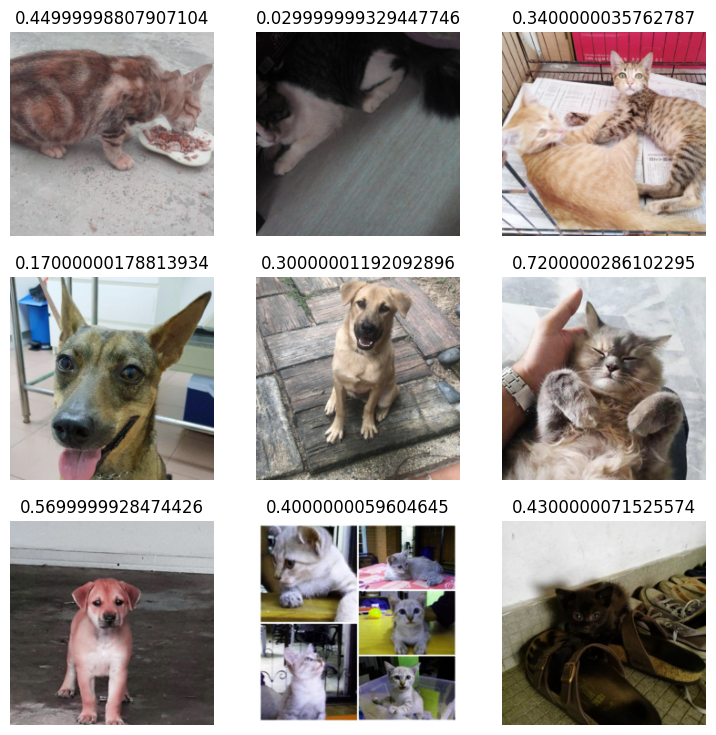

In [19]:
dls.show_batch()


In [44]:
from timm import create_model

model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

In [72]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [45]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(petfinder_rmse)).to_fp16()


c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


SuggestedLRs(valley=2.5700013793539256e-05)

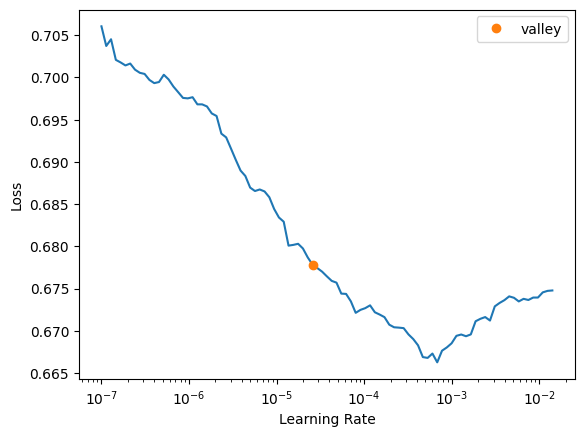

In [ ]:
learn.lr_find(end_lr=3e-2)


In [ ]:
learn.fit_one_cycle(10, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=3)])


Better model found at epoch 0 with valid_loss value: 0.6537166237831116.
Better model found at epoch 1 with valid_loss value: 0.6444112658500671.
Better model found at epoch 3 with valid_loss value: 0.6409010291099548.
No improvement since epoch 3: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

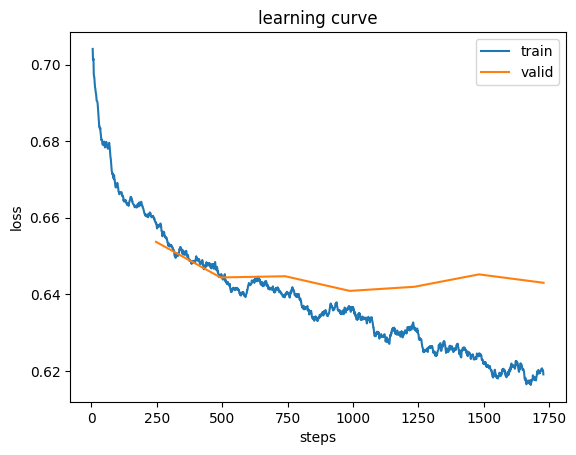

In [ ]:
learn.recorder.plot_loss()


The learning curve shows that training loss decreases consistently, while validation loss improves until about step 744 (epoch 3), after which it plateaus 

In [ ]:
learn = learn.to_fp32()
learn.save('fine-tuned-fastai')
learn.export()


# 3 Swin Transformer with images + metadata

In [111]:
train_df.head()

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              0     1     1     1       0          0      0        0      0   
1              0     1     1     0       0          0      0        1      0   
2              0     1     1     1       0          1      0        0      0   
3              0     0     1     1       0          0      1        0      0   
4              0     1     1     1       0          0      1        0      0   

   Occlusion  Info  Blur  Pawpularity  \
0          0     0     0           40   
1          0     0     0           64   
2          0     0     0           26   
3          0     0     0           73   
4          0     0     0           39   

                                                    path  norm_score  bins  \
0  src/inputs/train/48d53aeabee4f92f77eee3a323343c77.jpg        0.40    17   
1  src/inputs/train/b60e82fd313066b801fa4431d1ce4f4e.jpg        0.64    27   
2  src/inputs/train/09ae71fc4eda1e0ae05680d1950bc009.jpg        0.26    11   
3  src/inputs/train/263879abce68de4af02ef5f7ef873d24.jpg        0.73    31   
4  src/inputs/train/4ea0587a137c7983ca92851b6cb36ca1.jpg        0.39    16   

   fold  
0     8  
1     9  
2     7  
3     1  
4     1

<Axes: >

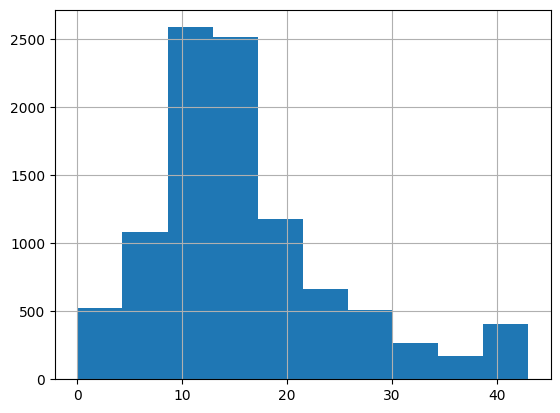

In [112]:
import numpy as np
#Sturges' rule
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
# num_bins
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<Axes: xlabel='fold'>

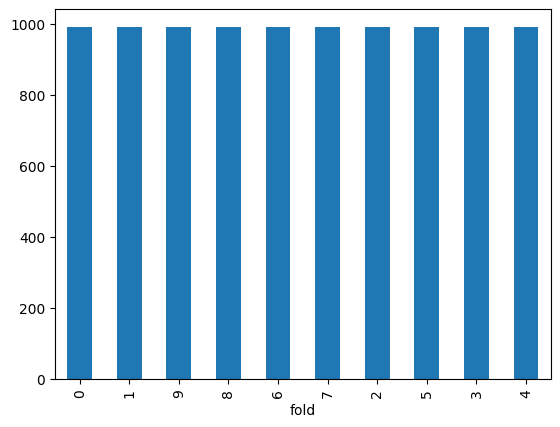

In [113]:

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
seed = 999
train_df['fold'] = -1

N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [114]:
import torchtext.vocab as vocab

In [115]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

glove_model = load_glove_model(BASE_PATH+"glove.6B.50d.txt")

Loading Glove Model
400000 words loaded!


In [116]:
import torch
metadata_glove = torch.zeros(12,50).cuda()
metadata_glove[0] = torch.tensor(glove_model['focus'])
metadata_glove[1] = torch.tensor(glove_model['eyes'])
metadata_glove[2] = torch.tensor(glove_model['face'])
metadata_glove[3] = torch.tensor(glove_model['near'])
metadata_glove[4] = torch.tensor(glove_model['action'])
metadata_glove[5] = torch.tensor(glove_model['accessory'])
metadata_glove[6] = torch.tensor(glove_model['group'])
metadata_glove[7] = torch.tensor(glove_model['collage'])
metadata_glove[8] = torch.tensor(glove_model['human'])
metadata_glove[9] = torch.tensor(glove_model['occlusion'])
metadata_glove[10] = torch.tensor(glove_model['info'])
metadata_glove[11] = torch.tensor(glove_model['blur'])

In [117]:
glove_model

{'the': array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
        -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
         2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
         1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
        -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
        -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
         4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
         7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
        -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
         1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01]),
 ',': array([ 0.013441,  0.23682 , -0.16899 ,  0.40951 ,  0.63812 ,  0.47709 ,
        -0.42852 , -0.55641 , -0.364   , -0.23938 ,  0.13001 , -0.063734,
        -0.39575 , -0.48162 ,  0.23291 ,  0.090201, -0.13324 ,  0.078639,
        -0.41634 , -0.15428 ,  0.1

In [118]:

# Show 5 sample words and their vectors
for i, (word, vector) in enumerate(glove_model.items()):
    print(f"{word}: {vector[:10]}...")  # Show only first 10 dimensions 
    if i == 4:
        break


the: [ 0.418       0.24968    -0.41242     0.1217      0.34527    -0.044457
 -0.49688    -0.17862    -0.00066023 -0.6566    ]...
,: [ 0.013441  0.23682  -0.16899   0.40951   0.63812   0.47709  -0.42852
 -0.55641  -0.364    -0.23938 ]...
.: [ 0.15164  0.30177 -0.16763  0.17684  0.31719  0.33973 -0.43478 -0.31086
 -0.44999 -0.29486]...
of: [ 0.70853  0.57088 -0.4716   0.18048  0.54449  0.72603  0.18157 -0.52393
  0.10381 -0.17566]...
to: [ 0.68047  -0.039263  0.30186  -0.17792   0.42962   0.032246 -0.41376
  0.13228  -0.29847  -0.085253]...


In [119]:
train_df

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  \
0                 0     1     1     1       0          0      0        0   
1                 0     1     1     0       0          0      0        1   
2                 0     1     1     1       0          1      0        0   
3                 0     0     1     1       0          0      1        0   
4                 0     1     1     1       0          0      1        0   
...             ...   ...   ...   ...     ...        ...    ...      ...   
9907              0     1     1     1       0          0      0        0   
9908              0     1     1     1       0          0      0        0   
9909              0     1     1     1       0          0      0        0   
9910              0     1     1     1       0          0      0        0   
9911              0     1     1     1       0          0      1        0   

      Human  Occlusion  Info  Blur  Pawpularity  \
0         0          0     0     0           40   
1         0          0     0     0           64   
2         0          0     0     0           26   
3         0          0     0     0           73   
4         0          0     0     0           39   
...     ...        ...   ...   ...          ...   
9907      1          1     0     0           31   
9908      0          0     0     0           25   
9909      0          0     0     0           60   
9910      1          0     0     0           66   
9911      0          0     0     0           27   

                                                       path  norm_score  bins  \
0     src/inputs/train/48d53aeabee4f92f77eee3a323343c77.jpg        0.40    17   
1     src/inputs/train/b60e82fd313066b801fa4431d1ce4f4e.jpg        0.64    27   
2     src/inputs/train/09ae71fc4eda1e0ae05680d1950bc009.jpg        0.26    11   
3     src/inputs/train/263879abce68de4af02ef5f7ef873d24.jpg        0.73    31   
4     src/inputs/train/4ea0587a137c7983ca92851b6cb36ca1.jpg        0.39    16   
...                                                     ...         ...   ...   
9907  src/inputs/train/94773ee6f04891c99bc4d37e8f20ff6f.jpg        0.31    13   
9908  src/inputs/train/85e7146eeb13644b1bac74b684ccf51f.jpg        0.25    10   
9909  src/inputs/train/8afb263d779be24c94f01046e5ec3e81.jpg        0.60    26   
9910  src/inputs/train/15bda3335526d2ab18834c65f93add56.jpg        0.66    28   
9911  src/inputs/train/bb263c3f1605cd5688a6fd1626f62466.jpg        0.27    11   

      fold  
0        8  
1        9  
2        7  
3        1  
4        1  
...    ...  
9907     5  
9908     0  
9909     2  
9910     9  
9911     9  

[9912 rows x 17 columns]

In [134]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [135]:
BATCH_SIZE = 40

In [136]:
from fastai.tabular.all import *

def get_data_meta(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)

    dls = TabularDataLoaders.from_df(train_df_f, 
                                      valid_col='is_valid',
                                      path = 'models/pets_swinf',
                                      y_names="norm_score", 
                                      valid_pct=0.2,
                                      seed=seed, #seed
                                      bs=BATCH_SIZE, 
                                      num_workers=8, 
                                      y_block=RegressionBlock,
                                      cont_names = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory','Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],
                                     
                                    )

    
    return dls

In [137]:
dls = get_data_meta(1)

In [138]:
from fastai.tabular.all import *
from fastai.vision.all import *

In [139]:
print("metadata_glove.shape",metadata_glove.shape)
print("*metadata_glove.shape",*metadata_glove.shape)

metadata_glove.shape torch.Size([12, 50])
*metadata_glove.shape 12 50


In [140]:
class PawpularModel_meta(nn.Module):
    def __init__(self, model_name='swin_large_patch4_window7_224', num_classes=[12,1], reduction_dim = 5,
                 n_meta_dim=[256, 128], pretrained=True):
        super().__init__()
        out_dim=num_classes[1] 
        n_meta_features=num_classes[0] # meta
        self.reduce_d = nn.Linear(50, reduction_dim) # embedding
        self.meta_order1 = nn.Linear(432+60, 100)
        self.meta_order2 = nn.Linear(100, 10)
        self.meta_order3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.5)


    def forward(self, ff, features):
        #print(features)
        #print(ff)
        embed = torch.zeros(BATCH_SIZE, *metadata_glove.shape).cuda()
        # metadata_glove shape is 12 x 50 and below for loop is scalar multplication
        for idx, eve_feature in enumerate(features):
            embed[idx] = (eve_feature*metadata_glove.T).T
        # to convert 50 dim to 5
        embed_reduce = self.reduce_d(embed) 
        # to normalize each : convert 5 values in each to 1 by summing
        embed_norm = torch.norm(embed_reduce, dim=2)
        # adding 1 extra dim for division 
        embed_norm = embed_norm.unsqueeze(2)
        # normalize and output will be B x 12 x 5 shape
        embed_reduce = embed_reduce/embed_norm 
        #embed_reduce = embed
        #multplication 12 x 5 and 5 x 12 = 12 x 12 shape then flatten to 144, Batch size will be inlcude in all so 144 mean [B, 144]
        dot_result = torch.bmm(embed_reduce, embed_reduce.permute(0,2,1)).reshape(BATCH_SIZE, -1)
        dot_tanh = torch.tanh(dot_result) 
        dot_relu = torch.relu(dot_result) 
        dot_sig = torch.sigmoid(dot_result) 
        #Concatenation → (BATCH_SIZE, 432) (since 144 × 3 = 432) 12 x 12 passed to each activation
        hig_order = torch.cat([dot_tanh, dot_relu, dot_sig], 1)
        # Now concatenate 432 and 12 x 5=60 (reduced embdedding), and that's why in linear 432+60 dimension is passed
        all_order = torch.cat([embed_reduce.reshape(BATCH_SIZE, -1), hig_order], 1)
        
        out1 = self.meta_order1(self.dropout(all_order))
        out2 = self.meta_order2(self.dropout(out1))
        out3 = self.meta_order3(self.dropout(out2))
        return out3

In [141]:
def get_learner_meta(fold_num):
    data = get_data_meta(fold_num)
    model = PawpularModel_meta()

    learn = Learner(data, model, loss_func = petfinder_rmse, metrics=petfinder_rmse) 
   
    return learn

In [142]:
def get_data_pic(fold):

    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=seed, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               #batch_tfms=setup_aug_tfms([RandomErasing(),  Rotate(),   Flip()]))
                               batch_tfms=setup_aug_tfms([RandomErasing(), Rotate(),  Zoom(), Brightness(), Flip(), Contrast(), Saturation()])) #pass in batch_tfms
    
    return dls

In [143]:
def get_learner_pic(fold_num):
    data = get_data_pic(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=1)
  
    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=AccumMetric(func=petfinder_rmse), cbs=[MixUp(0.2)]).to_fp16()
    
    return learn

In [ ]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(BASE_PATH+'test/'+x)+'.jpg')
test_df = test_df.drop(columns=['Id'])

In [107]:
test_df

Subject Focus  Eyes  Face  Near  Action  Accessory  Group  Collage  Human  \
0              1     0     1     0       0          1      1        0      0   
1              0     1     0     0       0          0      1        1      0   
2              0     0     0     1       0          1      1        1      0   
3              1     0     1     0       0          0      0        0      0   
4              1     1     1     0       1          1      0        1      0   
5              0     0     1     1       1          1      1        1      1   
6              1     0     0     0       1          1      0        1      0   
7              1     0     1     0       0          0      0        0      1   

   Occlusion  Info  Blur  Pawpularity  \
0          1     0     1            1   
1          0     0     0            1   
2          1     1     1            1   
3          0     1     0            1   
4          1     1     0            1   
5          0     1     0            1   
6          1     1     1            1   
7          0     0     1            1   

                                                   path  
0  src/inputs/test/4128bae22183829d2b5fea10effdb0c3.jpg  
1  src/inputs/test/43a2262d7738e3d420d453815151079e.jpg  
2  src/inputs/test/4e429cead1848a298432a0acad014c9d.jpg  
3  src/inputs/test/80bc3ccafcc51b66303c2c263aa38486.jpg  
4  src/inputs/test/8f49844c382931444e68dffbe20228f4.jpg  
5  src/inputs/test/b03f7041962238a7c9d6537e22f9b017.jpg  
6  src/inputs/test/c978013571258ed6d4637f6e8cc9d6a3.jpg  
7  src/inputs/test/e0de453c1bffc20c22b072b34b54e50f.jpg

In [108]:
from timm import create_model


Fold 0 results


No improvement since epoch 2: early stopping


meta process is done!


KeyboardInterrupt: 

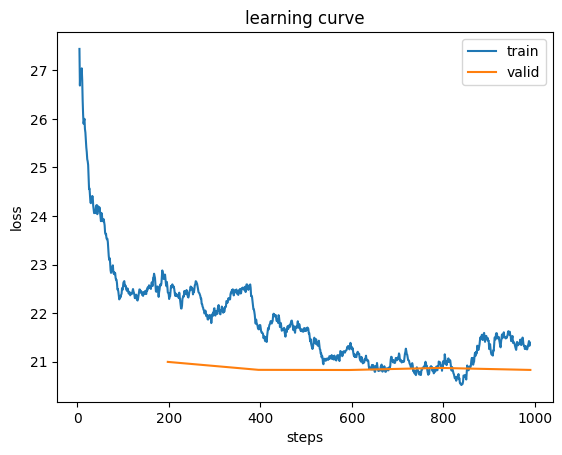

In [145]:
import gc
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn_meta = get_learner_meta(fold_num=i) 


    learn_meta.fit_one_cycle(10, cbs=[EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    val_mse_meta = learn_meta.recorder.values[-1][2]
    learn_meta.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls_meta = TabularDataLoaders.from_df(train_df, 
                                      valid_col='is_valid',
                                      path = 'models/pets_swinf',
                                      y_names="norm_score", 
                                      #valid_pct=0.2,
                                      seed=seed, #seed
                                      bs=BATCH_SIZE, 
                                      num_workers=8, 
                                      y_block=RegressionBlock,
                                      cont_names = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',\
                                                    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
                                    )
                                     
    
    test_dl_meta = dls_meta.test_dl(test_df)
    
    preds_meta, _ = learn_meta.get_preds(dl=test_dl_meta)
    
    
    
    del learn_meta

    torch.cuda.empty_cache()

    gc.collect() 
    
    print('meta process is done!')
    
    learn_pic = get_learner_pic(fold_num=i)

    learn_pic.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    val_mse_pic = learn_pic.recorder.values[-1][2]

    learn_pic.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls_pic = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               #valid_pct=0.2, #80-20 train-validation random split
                               seed=seed, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                                batch_tfms=setup_aug_tfms([RandomErasing(),  Rotate(),  Brightness(), Flip(), Contrast(), Saturation()])) 
    
    test_dl_pic = dls_pic.test_dl(test_df)
    
    preds_pic, _ = learn_pic.tta(dl=test_dl_pic, n=5, beta=0)
    
    
    
    del learn_pic
 
    torch.cuda.empty_cache()

    gc.collect()
    print('pic process is done!')

    meta_weight = torch.nn.functional.relu_(torch.tensor(20.5-val_mse_meta))**2
    pic_weight = torch.nn.functional.relu_(torch.tensor(20.5-val_mse_pic))**2
   
    meta_weight = meta_weight/(meta_weight+pic_weight)
    pic_weight = pic_weight/(meta_weight+pic_weight)
    print('meta_weight is ' + str(meta_weight.item()))
    print('pic_weight is ' + str(pic_weight.item()))
    all_preds.append(preds_meta*meta_weight+preds_pic*pic_weight)

# Improvements

In [60]:
# Training parameters
SEED = 42
N_FOLDS = 5
BATCH_SIZE = 32
N_EPOCHS = 20 # Increased max epochs since Early Stopping will stop it early
LEARNING_RATE = 1e-5
IMG_SIZE = 224
METADATA_DIM = 12 # Number of metadata features

# Early Stopping parameters
ES_PATIENCE = 5 # Stop if validation metric doesn't improve for 5 epochs
ES_MIN_DELTA = 0.001 # Minimum change to qualify as an improvement

MODEL_NAME = 'swin_large_patch4_window7_224'
set_seed(SEED, reproducible=True)

In [61]:
# --- 2. CUSTOM METRIC AND LOSS FUNCTION ---

# Metric: Pawpularity RMSE (Root Mean Squared Error)
def petfinder_rmse(input, target, sigmoid=True):
    """
    Calculates RMSE. If sigmoid=True (used during training metric calculation), 
    it scales the raw model output (logits) to the 0-100 range.
    """
    # Ensure input and target are flattened
    input = input.flatten()
    target = target.flatten()
    
    # Apply activation and scale if the input is raw logits
    if sigmoid:
        # Scale predictions from 0-1 to 0-100 range for RMSE calculation
        score = 100 * torch.sigmoid(input)
    else:
        # If the input is already scaled (used for OOF prediction reporting)
        score = input

    return torch.sqrt(F.mse_loss(score, target))


# Previous IMprovement code


#################### FOLD 0 START ####################
Training META model for Fold 0


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 3: early stopping
✅ Meta model saved: model_meta_fold_0.pkl


✅ META model done!
Training IMAGE model for Fold 0


Better model found at epoch 0 with valid_loss value: 0.6444210410118103.
Better model found at epoch 1 with valid_loss value: 0.6417587995529175.
Better model found at epoch 2 with valid_loss value: 0.6414822340011597.
No improvement since epoch 2: early stopping
✅ Pic model saved: model_pic_fold_0.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 0: meta_weight=0.4678, pic_weight=0.5322
✅ Fold 0 done and predictions stored.
#######################################################


#################### FOLD 1 START ####################
Training META model for Fold 1


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 0: early stopping
✅ Meta model saved: model_meta_fold_1.pkl


✅ META model done!
Training IMAGE model for Fold 1


Better model found at epoch 0 with valid_loss value: 0.6448397040367126.
Better model found at epoch 1 with valid_loss value: 0.6401500105857849.
Better model found at epoch 2 with valid_loss value: 0.6367265582084656.
Better model found at epoch 3 with valid_loss value: 0.6366969347000122.
Better model found at epoch 4 with valid_loss value: 0.6365203857421875.
✅ Pic model saved: model_pic_fold_1.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 1: meta_weight=0.4545, pic_weight=0.5455
✅ Fold 1 done and predictions stored.
#######################################################


#################### FOLD 2 START ####################
Training META model for Fold 2


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 7: early stopping
✅ Meta model saved: model_meta_fold_2.pkl


✅ META model done!
Training IMAGE model for Fold 2


Better model found at epoch 0 with valid_loss value: 0.6478550434112549.
Better model found at epoch 1 with valid_loss value: 0.6420688033103943.
Better model found at epoch 3 with valid_loss value: 0.6417946219444275.
✅ Pic model saved: model_pic_fold_2.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 2: meta_weight=0.4648, pic_weight=0.5352
✅ Fold 2 done and predictions stored.
#######################################################


#################### FOLD 3 START ####################
Training META model for Fold 3


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 1: early stopping
✅ Meta model saved: model_meta_fold_3.pkl


✅ META model done!
Training IMAGE model for Fold 3


Better model found at epoch 0 with valid_loss value: 0.6518318057060242.
Better model found at epoch 1 with valid_loss value: 0.6438672542572021.
Better model found at epoch 2 with valid_loss value: 0.6408976912498474.
✅ Pic model saved: model_pic_fold_3.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 3: meta_weight=0.4612, pic_weight=0.5388
✅ Fold 3 done and predictions stored.
#######################################################


#################### FOLD 4 START ####################
Training META model for Fold 4


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 0: early stopping
✅ Meta model saved: model_meta_fold_4.pkl


✅ META model done!
Training IMAGE model for Fold 4


Better model found at epoch 0 with valid_loss value: 0.6481935381889343.
Better model found at epoch 1 with valid_loss value: 0.6464517116546631.
Better model found at epoch 2 with valid_loss value: 0.6410900354385376.
Better model found at epoch 3 with valid_loss value: 0.639853835105896.
✅ Pic model saved: model_pic_fold_4.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 4: meta_weight=0.4603, pic_weight=0.5397
✅ Fold 4 done and predictions stored.
#######################################################


#################### FOLD 5 START ####################
Training META model for Fold 5


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 0: early stopping
✅ Meta model saved: model_meta_fold_5.pkl


✅ META model done!
Training IMAGE model for Fold 5


Better model found at epoch 0 with valid_loss value: 0.6469523310661316.
Better model found at epoch 1 with valid_loss value: 0.6425560712814331.
Better model found at epoch 2 with valid_loss value: 0.6401253342628479.
Better model found at epoch 3 with valid_loss value: 0.6392555236816406.
Better model found at epoch 4 with valid_loss value: 0.6386694312095642.
✅ Pic model saved: model_pic_fold_5.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 5: meta_weight=0.4561, pic_weight=0.5439
✅ Fold 5 done and predictions stored.
#######################################################


#################### FOLD 6 START ####################
Training META model for Fold 6


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 1: early stopping
✅ Meta model saved: model_meta_fold_6.pkl


✅ META model done!
Training IMAGE model for Fold 6


Better model found at epoch 0 with valid_loss value: 0.6461911797523499.
Better model found at epoch 1 with valid_loss value: 0.6430521607398987.
Better model found at epoch 2 with valid_loss value: 0.6402021646499634.
No improvement since epoch 2: early stopping
✅ Pic model saved: model_pic_fold_6.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 6: meta_weight=0.4627, pic_weight=0.5373
✅ Fold 6 done and predictions stored.
#######################################################


#################### FOLD 7 START ####################
Training META model for Fold 7


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 0: early stopping
✅ Meta model saved: model_meta_fold_7.pkl


✅ META model done!
Training IMAGE model for Fold 7


Better model found at epoch 0 with valid_loss value: 0.6463363766670227.
Better model found at epoch 1 with valid_loss value: 0.6434944868087769.
Better model found at epoch 2 with valid_loss value: 0.6428605914115906.
Better model found at epoch 3 with valid_loss value: 0.6419989466667175.
✅ Pic model saved: model_pic_fold_7.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 7: meta_weight=0.4657, pic_weight=0.5343
✅ Fold 7 done and predictions stored.
#######################################################


#################### FOLD 8 START ####################
Training META model for Fold 8


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 4: early stopping
✅ Meta model saved: model_meta_fold_8.pkl


✅ META model done!
Training IMAGE model for Fold 8


Better model found at epoch 0 with valid_loss value: 0.6478273868560791.
Better model found at epoch 1 with valid_loss value: 0.641879677772522.
Better model found at epoch 2 with valid_loss value: 0.6400129199028015.
✅ Pic model saved: model_pic_fold_8.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 8: meta_weight=0.4597, pic_weight=0.5403
✅ Fold 8 done and predictions stored.
#######################################################


#################### FOLD 9 START ####################
Training META model for Fold 9


C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))
C:\Users\user\AppData\Local\Temp\ipykernel_70524\2919260327.py:2: UserWarning: Using a target size (torch.Size([40, 1])) that is different to the input size (torch.Size([40])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return 100*tor

No improvement since epoch 4: early stopping
✅ Meta model saved: model_meta_fold_9.pkl


✅ META model done!
Training IMAGE model for Fold 9


Better model found at epoch 0 with valid_loss value: 0.6505239605903625.
Better model found at epoch 1 with valid_loss value: 0.6468312740325928.
Better model found at epoch 2 with valid_loss value: 0.643302857875824.
Better model found at epoch 3 with valid_loss value: 0.6426845788955688.
Better model found at epoch 4 with valid_loss value: 0.6424489617347717.
✅ Pic model saved: model_pic_fold_9.pkl


preds_meta shape: torch.Size([8, 1])
preds_pic shape: torch.Size([8, 1])
✅ IMAGE model done!
FOLD 9: meta_weight=0.4656, pic_weight=0.5344
✅ Fold 9 done and predictions stored.
#######################################################

Combining predictions from all folds...
✅ Final predictions computed!
 Final predictions saved as final_predictions.pt
 All folds completed successfully!


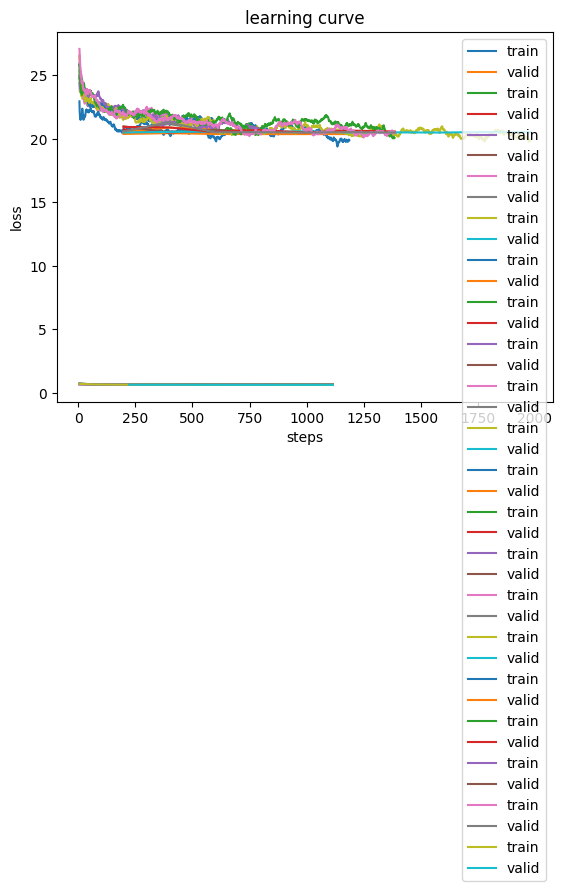

In [48]:
import gc
import torch
import numpy as np

# Number of folds (set according to your CV setup)
N_FOLDS = 10  

# To store fold predictions
all_preds = []

for i in range(N_FOLDS):

    print(f"\n{'#'*20} FOLD {i} START {'#'*20}")

    # ---------------- META MODEL ----------------
    print(f"Training META model for Fold {i}")
    learn_meta = get_learner_meta(fold_num=i)

    # Fit meta model
    learn_meta.fit_one_cycle(
        10, 
        cbs=[EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]
    )

    # Validation RMSE for meta
    val_mse_meta = learn_meta.recorder.values[-1][2]
    learn_meta.recorder.plot_loss()

    # Save meta model
    learn_meta.export(f'model_meta_fold_{i}.pkl')
    print(f"✅ Meta model saved: model_meta_fold_{i}.pkl")

    # Prepare dataloader for testing (sorted order)
    test_df_sorted = test_df.sort_values("path").reset_index(drop=True)

    dls_meta = TabularDataLoaders.from_df(
        train_df,
        valid_col='is_valid',
        path='models/pets_swinf',
        y_names="norm_score",
        seed=42,
        bs=BATCH_SIZE,
        num_workers=8,
        y_block=RegressionBlock,
        cont_names=[
            'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
            'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
        ]
    )

    test_dl_meta = dls_meta.test_dl(test_df_sorted)
    preds_meta, _ = learn_meta.get_preds(dl=test_dl_meta)

    del dls_meta
    del learn_meta
    torch.cuda.empty_cache()
    gc.collect()
    print('✅ META model done!')

    # ---------------- IMAGE MODEL ----------------
    print(f"Training IMAGE model for Fold {i}")
    learn_pic = get_learner_pic(fold_num=i)

    learn_pic.fit_one_cycle(
        5, 2e-5, 
        cbs=[
            SaveModelCallback(),
            EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)
        ]
    )

    # Validation RMSE for pic
    val_mse_pic = learn_pic.recorder.values[-1][2]
    learn_pic.recorder.plot_loss()

    # Save pic model
    learn_pic.export(f'model_pic_fold_{i}.pkl')
    print(f"✅ Pic model saved: model_pic_fold_{i}.pkl")

    # Prepare dataloader for testing (same sorted test_df)
    dls_pic = ImageDataLoaders.from_df(
        train_df,
        seed=42,
        fn_col='path',
        label_col='norm_score',
        y_block=RegressionBlock,
        bs=BATCH_SIZE,
        num_workers=8,
        item_tfms=Resize(224),
        batch_tfms=setup_aug_tfms([
            RandomErasing(), Rotate(), Brightness(), Flip(), Contrast(), Saturation()
        ])
    )

    test_dl_pic = dls_pic.test_dl(test_df_sorted)
    preds_pic, _ = learn_pic.tta(dl=test_dl_pic, n=5, beta=0)

    # 🔍 Log shapes to check consistency
    print(f"preds_meta shape: {preds_meta.shape}")
    print(f"preds_pic shape: {preds_pic.shape}")

    # 🔧 Safety fix: ensure same number of predictions
    min_len = min(len(preds_meta), len(preds_pic))
    preds_meta = preds_meta[:min_len]
    preds_pic = preds_pic[:min_len]

    del dls_pic
    del learn_pic
    torch.cuda.empty_cache()
    gc.collect()
    print('✅ IMAGE model done!')

    # ---------------- WEIGHTED ENSEMBLE ----------------
    # Compute inverse RMSE-based weights
    meta_weight = 1 / val_mse_meta
    pic_weight = 1 / val_mse_pic

    total = meta_weight + pic_weight
    meta_weight = meta_weight / total
    pic_weight = pic_weight / total

    print(f"FOLD {i}: meta_weight={meta_weight:.4f}, pic_weight={pic_weight:.4f}")

    # Weighted ensemble prediction
    fold_pred = preds_meta * meta_weight + preds_pic * pic_weight
    all_preds.append(fold_pred)

    print(f"✅ Fold {i} done and predictions stored.")
    print(f"{'#'*55}\n")

# ---------------- FINAL AVERAGING ----------------
print("Combining predictions from all folds...")
final_preds = torch.stack(all_preds).mean(dim=0)

print("✅ Final predictions computed!")

# Save final predictions
torch.save(final_preds, "final_predictions.pt")
print(" Final predictions saved as final_predictions.pt")

print(" All folds completed successfully!")
